In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pysam 

In [4]:
import numpy as np

In [5]:
import glob

In [6]:
import seaborn as sns

In [7]:
files = glob.glob('/home/antonl/projects/XAlgo/F1_Fibro_downsampling/bam_downsampled/*.bam')

In [8]:
folders = glob.glob('/home/antonl/projects/XAlgo/F1_Fibro_downsampling/*')

In [9]:
import os

In [10]:
donor_file = '/vireo_out/donor_ids.tsv'

In [14]:
vireo_df = pd.read_csv('/home/antonl/projects/XAlgo/F1_Fibro_from_SS3_paper/vireo_out/donor_ids.tsv', sep='\t', index_col=0)


In [15]:
passing_cells = list(vireo_df.index[vireo_df['n_vars']>50])

In [16]:
N = len(passing_cells)

In [26]:
bamfile = '/home/antonl/projects/XAlgo/F1_Fibro_downsampling/bam_downsampled/Smartseq2_Fibroblasts_Anton_rerun.chrX.0.0001.sorted.bam'

In [17]:
fraction_assigned = {}
for folder in folders:
    
    f = folder.split('/')[-1].split('_')
    if f[0] == 'Snakefile':
        continue
    if f[1] == 'downsampled':
        continue
    bam_fraction = float(f[1])
    vcf_fraction = float(f[-1])

    p = folder+donor_file 
    if os.path.exists(p):
        bla = pd.read_csv(p, sep='\t', index_col=0).reindex(passing_cells)
        if bam_fraction in fraction_assigned:
            fraction_assigned[bam_fraction][vcf_fraction] = 1-(bla['donor_id'] == 'unassigned').sum()/N
        else:
            fraction_assigned[bam_fraction] = {}
            fraction_assigned[bam_fraction][vcf_fraction] = 1-(bla['donor_id'] == 'unassigned').sum()/N
    else:
        if bam_fraction in fraction_assigned:
            fraction_assigned[bam_fraction][vcf_fraction] = np.nan
        else:
            fraction_assigned[bam_fraction] = {}
            fraction_assigned[bam_fraction][vcf_fraction] = np.nan
    

In [18]:
fraction_assigned_df = pd.DataFrame(fraction_assigned).sort_index(axis=1).sort_index(axis=0,ascending=False).fillna(0)

In [20]:
n_x_linked_vars = 39729

In [27]:
from collections import Counter

def get_reads_per_cell(bamfile):
    fraction = float('.'.join(bamfile.split('/')[-1].split('.')[-4:-2]))
    bam = pysam.AlignmentFile(bamfile, 'rb')

    cell_counter = Counter()
    for read in bam.fetch():
        cell_counter.update({read.get_tag('BC'):1})
    df = pd.DataFrame(cell_counter, index=[fraction]).T
    return df

df_list = [get_reads_per_cell(bamfile) for bamfile in files]

df_readcounts_X = pd.concat(df_list, axis=1, join='outer').fillna(0)

df_readcounts_X = df_readcounts_X.sort_index(axis=1).astype(int)

df_readcounts_X = df_readcounts_X.reindex(passing_cells)

full_read_counts_df = pd.read_csv('/home/michaelhj/projects/smartseq3/Smartseq2_Fibroblasts_Anton_rerun/zUMIs/zUMIs_output/Smartseq3_Fibroblastskept_barcodes.txt', index_col=0)

full_count_list = []
for fraction in df_readcounts_X.columns:
    s = full_read_counts_df['n'].copy()
    s = s*fraction
    s.name = fraction
    full_count_list.append(s.astype(int))

df_readcounts_full = pd.concat(full_count_list, axis=1, join='outer').fillna(0)
df_readcounts_full = df_readcounts_full.sort_index(axis=1).astype(int)
df_readcounts_full = df_readcounts_full.reindex(passing_cells)

In [21]:
fraction_assigned_df.index = [int(n_x_linked_vars*frac) for frac in fraction_assigned_df.index]

In [35]:
fraction_assigned_df.columns = [df_readcounts_X.median().astype(int)[frac] for frac in fraction_assigned_df.columns]

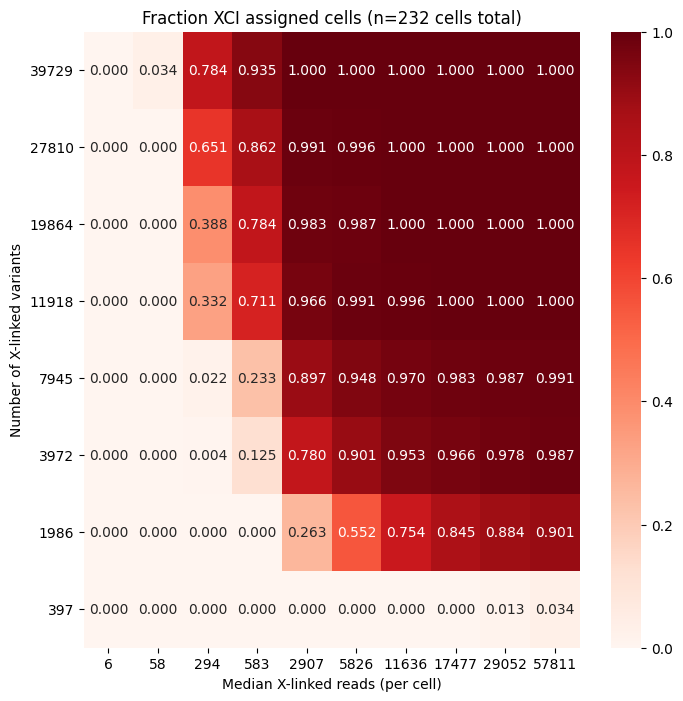

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.heatmap(fraction_assigned_df, cmap='Reds', ax=ax, fmt='.3f', annot=True)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Median X-linked reads (per cell)')
ax.set_ylabel('Number of X-linked variants')
ax.set_title('Fraction XCI assigned cells (n={} cells total)'.format(N))
#plt.savefig('Fibroblasts_XCI_downsampling_heatmap.pdf')
plt.show()

In [38]:
import matplotlib as mpl
import matplotlib.cm as cm
   
norm = mpl.colors.Normalize(vmin=0, vmax=40000)
cmap = cm.Blues

m = cm.ScalarMappable(norm=norm, cmap=cmap)

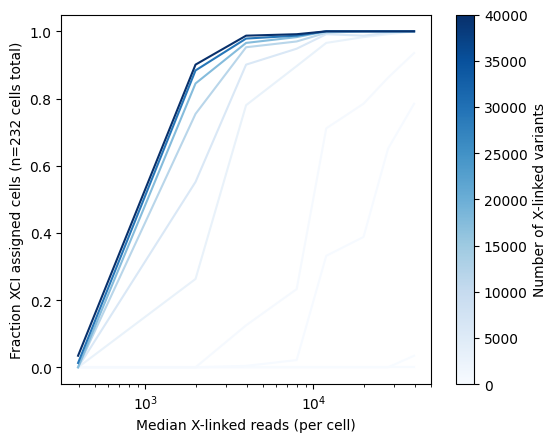

In [39]:
fig, ax = plt.subplots(1,1)
for n_reads, s in fraction_assigned_df.iteritems():
    ax.plot(s.index, s.values, color=m.to_rgba(n_reads))
ax.set_xscale('log')
fig.colorbar(mappable=m, label='Number of X-linked variants')
ax.set_box_aspect(1)
ax.set_xlabel('Median X-linked reads (per cell)')
ax.set_ylabel('Fraction XCI assigned cells (n={} cells total)'.format(N))
plt.savefig('figures/Fig1D.pdf')
plt.show()


In [40]:
df_readcounts_X.median().astype(int)

0.0001        6
0.0010       58
0.0050      294
0.0100      583
0.0500     2907
0.1000     5826
0.2000    11636
0.3000    17477
0.5000    29052
1.0000    57811
dtype: int64

In [41]:
df_readcounts_X.median().astype(int)/df_readcounts_full.median().astype(int)

0.0001    0.025532
0.0010    0.024649
0.0050    0.024983
0.0100    0.024771
0.0500    0.024702
0.1000    0.024753
0.2000    0.024719
0.3000    0.024751
0.5000    0.024686
1.0000    0.024562
dtype: float64

In [42]:
df_readcounts_full.median().astype(int)

0.0001        235
0.0010       2353
0.0050      11768
0.0100      23536
0.0500     117684
0.1000     235370
0.2000     470740
0.3000     706111
0.5000    1176852
1.0000    2353706
dtype: int64

In [43]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

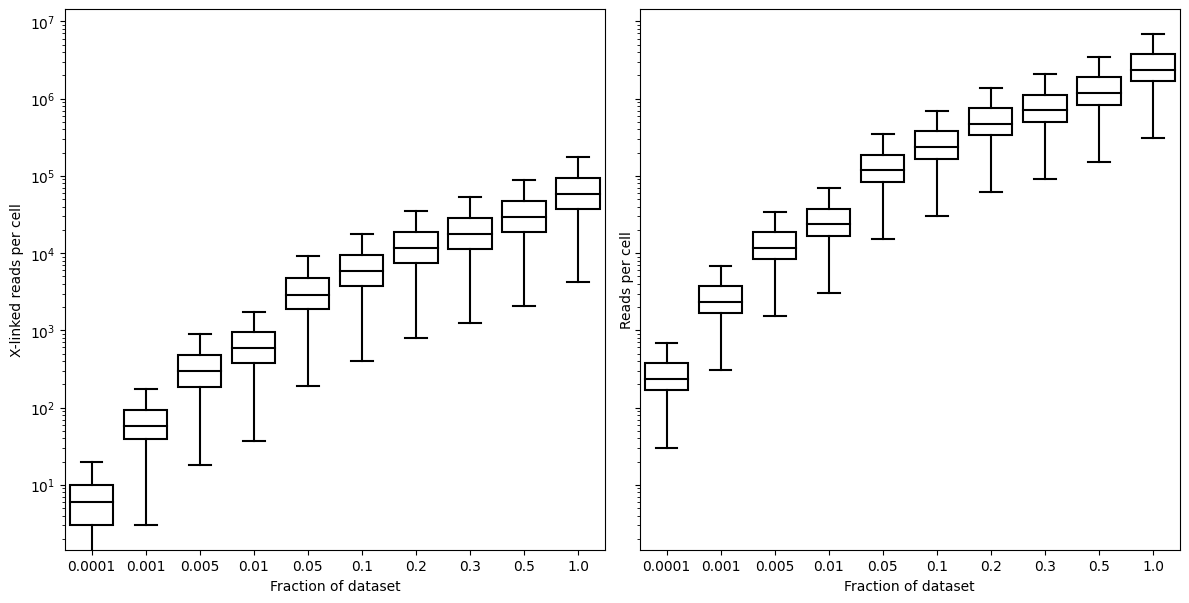

In [45]:
fig, ax = plt.subplots(1,2, figsize=(12,12), sharey=True)
sns.boxplot(x='variable', y='value', data=pd.melt(df_readcounts_X), **PROPS, showfliers=False, ax=ax[0])
#sns.stripplot(x='variable', y='value', data=pd.melt(df_readcounts_X), ax=ax[0], s=2, color='black')
ax[0].set_yscale('log')
ax[0].set_xlabel('Fraction of dataset')
ax[0].set_ylabel('X-linked reads per cell')
ax[0].set_box_aspect(1)
sns.boxplot(x='variable', y='value', data=pd.melt(df_readcounts_full), **PROPS, showfliers=False, ax=ax[1])
#sns.stripplot(x='variable', y='value', data=pd.melt(df_readcounts_full), ax=ax[1], s=2, color='black')
ax[1].set_yscale('log')
ax[1].set_xlabel('Fraction of dataset')
ax[1].set_ylabel('Reads per cell')
ax[1].set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Supp_Fig_1.pdf')
plt.show()